# Compulsory Assignment 1: Dense neural networks - Implementing an ANN with Keras

Please fill out the the group name, number, members and optionally the group name below.

**Group number**: 30.  
**Group member 1**: Peder Ørmen Bukaasen.   
**Group member 2**: Bård Tollef Pedersen.   
**Group member 3**: Eivind Lid Trøen.   
**Group name (optional)**:  

# Assignment submission

To complete this assignment, answer the all the questions in this notebook and write the code required to implement different models. **Submit the assignment by handing in this notebook as both an .ipynb file and a .pdf file**.

Here are some do’s and don’ts for the submission:

- Read questions thoroughly before answering.
- Make sure to answer all questions.
- Ensure all code cells are run.
- Label all axes in plots.
- Ensure all figures are visible in the PDF.

# Introduction

In this assignment we will continue with the task of classifying handwritten digits from the MNIST dataset, used in the voluntary assignment where we designed a neural network from scratch. But, today you will implement the network using the Keras API of the TensorFlow library. TensorFlow and PyTorch are both free open-source software libraries intended to simplify multiplication of tensors, but are mostly used for the design and implementation of deep neural networks. Both libraries simplify the implementation of neural networks, and allow for faster training of networks by utlizing hardware acceleration with Graphical Processing Units (GPUs) or Tensor Processing Units (TPUs)

TensorFlow was developed by Google Brain for internal use in Google and was initially released under Apache 2.0 License in 2015 [1](https://en.wikipedia.org/wiki/TensorFlow). Keras was initially released as separate software library, developed by François Chollet, to simplify the Python interface for design of artificial neural networks. Up until version 2.3 Keras supported multiple backend libraries including TensorFlow, Microsoft Cognitive Toolkit, Theano, and PlaidML [2](https://en.wikipedia.org/wiki/Keras). When TensorFlow 2.0 was released in 2019, keras was included as a TensorFlow specific API that is accessible by:

```python
import tensorflow.keras as ks
```
PyTorch was originally developed by Meta AI (formerly known as Facebook) in 2016, but is now under umbrella of the Linux foundation, and is open-source under the BSD license [3](https://en.wikipedia.org/wiki/PyTorch). While TensorFlow was the most popular framework for a long time, PyTorch has been gaining more and more users in the last five years and is now more used in industry and is becoming more popular in research as well.

The lectures of DAT300 will be taught using the Keras API in TensorFlow, and we recommend you to stick with Keras and TensorFlow for this course as it is easier for beginners to get started with.

## Assignment structure

1. Part 1: Import, preprocess, and visualize the data.
2. Part 2: Use the Keras API to implement a Dense Neural Network (NN) that resembles the model given in the voluntary assignment.
3. Part 3: Design your own Dense Neural Network (NN) architecture for classifying MNIST in Keras.
4. Part 4: Train a Machine Learning classifier that you learned about in DAT200.
5. Part 5: Compare and discuss the results.

## Note on the voluntary assignment

Some of the questions in this task will ask you to compare the results from training this network to the results you had in the voluntary assignment with regard to training algorithm used and the time it took to train the network implemented with Numpy and with TensorFlow/PyTorch. If you did not do the voluntary assignment yourself, have a look at the solutions that should be posted and run through the solutions-notebook to get the results you need for a comparison.


## Library imports

In [1]:
# Make shure libraries are installed
!pip install xgboost
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 4.7 MB/s eta 0:00:00


In [2]:
import time
from tqdm import tqdm

import numpy as np
import pandas as pd
import tensorflow.keras as ks
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

from utilities import *

import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score

SEED = 458
RNG = np.random.default_rng(SEED) # Random number generator

# Task 1: Importing, preprocess and visualizing the data
To import the data of the MNIST dataset for this assignment
* Copy the data/ folder from the folder where you kept the last assignment, and run the load_data() function from the `utilities.py` file.
* Just download the data again by re-running the load_data() function from the `utilities.py` file.

In this assignment you yourselves will be responsible for the data-preprocessing. Use the cells below for preprocessing and visualization, and optionally some exploration of the dataset if you feel inclined.

## Importing data

In [3]:
datasets = load_mnist(verbose=0)
X_train, y_train = datasets['X_train'], datasets['y_train']
X_val,   y_val   = datasets['X_val'],   datasets['y_val']
X_test,  y_test  = datasets['X_test'],  datasets['y_test']

X_train = np.concatenate([X_train, X_val], axis=0)
y_train = np.concatenate([y_train, y_val], axis=0).astype('int32')

del datasets, X_val, y_val # Good to reduce uneccesary RAM usage

11490434/11490434 [==============================] - 0s 0us/step



## Task 1.1 Preprocessing
Preprocess the data in whatever way you find sensible. Remember to comment on what you do.

In [4]:
X_traing_xgb = X_train.reshape(X_train.shape[0], -1) / 255 # For xgboost/ml i need it to be flat before training and normilize the data
X_test_xgb = X_test.reshape(X_test.shape[0], -1) / 255
y_train_xgb = y_train # For xgboost/ml i need it as it is
y_test_xgb = y_test

X_train       = X_train.astype("float32")      /255  # Normilize the data for faster convergens
X_test        = X_test.astype("float32")       /255

y_train = ks.utils.to_categorical(y_train, num_classes=10) # Change from numbers to arrays, this for deep learning
y_test = ks.utils.to_categorical(y_test, num_classes=10)

## Task 1.2 Visualization
Visualize the data in whatever manner you find helpful/sensible and briefly comment on the plots.

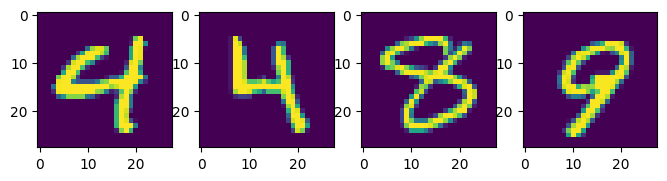

In [5]:
random_images = RNG.choice(X_train, replace=False, size=4)
fig, ax = plt.subplots(1,4,figsize=(8,8))
for i in range(random_images.shape[0]):
    ax[i].imshow(random_images[i])
plt.show()

# Task 2: TensorFlow vs. Numpy
In this task you will redesign the network you implemented in Numpy (from the voluntary assignment) using TensorFlow, and then compare the two implementations.
## Task 2.1: Implement the F1-score
In the cell below, implement or import a function for the F1-score metric.

In [6]:
from tensorflow.keras.metrics import F1Score
from tensorflow.keras import backend as K

# Needed this helper function for coorectly using the plot_training_history function from utiltys.
def f1_score_(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    f1 = 2 * precision * recall / (precision + recall + K.epsilon())
    return K.mean(f1)

## Task 2.2: Implement the network from the voluntary assignment
Implement a network with the following architecture:
* Input layer: (28, 28)
* Hidden layer: 30 units, sigmoid activation
* Output layer: 10 units, sigmoid activation

Compile the model using:
* The `'MSE'` loss function
* The `SGD` optimizer with `learning_rate=0.25`
* both `'accuracy'` and the implementation of the **F1-score** from Task 2.1 as metrics

Train the model using:
* batch size of 10 images
* 5 epochs
* A validation split of 1/6

Implement the model in the code cell(s) below.

In [7]:
model_va = ks.models.Sequential(
    [
        ks.layers.Input((28,28)), # input layer
        ks.layers.Flatten(),
        ks.layers.Dense(30, activation='sigmoid'),   # hidden layer
        ks.layers.Dense(10, activation='sigmoid') # output layer
        ])

model_va.summary()
model_va.compile(loss='MSE',
              optimizer=ks.optimizers.SGD(learning_rate=0.25),
              metrics=['accuracy', f1_score_])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 30)                23550     
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
Total params: 23860 (93.20 KB)
Trainable params: 23860 (93.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 2.3: Train the network and plot the training history
Train the model and plot the training history in the code cell(s) below. Use the same method for plotting the training process as in the voluntary assignment. Feel free to use the function `plot_training_history()` from `utilities.py`

In [8]:
time_va_start = time.time()
train_va = model_va.fit(X_train, y_train, epochs=5, batch_size=10, validation_split=(1/6))
time_va = time.time() - time_va_start

Epoch 1/5
5000/5000 [==============================] - 10s 2ms/step - loss: 0.0590 - accuracy: 0.6656 - f1_score_: 0.1999 - val_loss: 0.0370 - val_accuracy: 0.8366 - val_f1_score_: 0.4111
Epoch 2/5
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0300 - accuracy: 0.8668 - f1_score_: 0.4707 - val_loss: 0.0248 - val_accuracy: 0.8877 - val_f1_score_: 0.5204
Epoch 3/5
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0226 - accuracy: 0.8897 - f1_score_: 0.5296 - val_loss: 0.0205 - val_accuracy: 0.8995 - val_f1_score_: 0.5453
Epoch 4/5
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0195 - accuracy: 0.9001 - f1_score_: 0.5452 - val_loss: 0.0182 - val_accuracy: 0.9053 - val_f1_score_: 0.5585
Epoch 5/5
5000/5000 [==============================] - 9s 2ms/step - loss: 0.0176 - accuracy: 0.9059 - f1_score_: 0.5566 - val_loss: 0.0168 - val_accuracy: 0.9094 - val_f1_score_: 0.5672


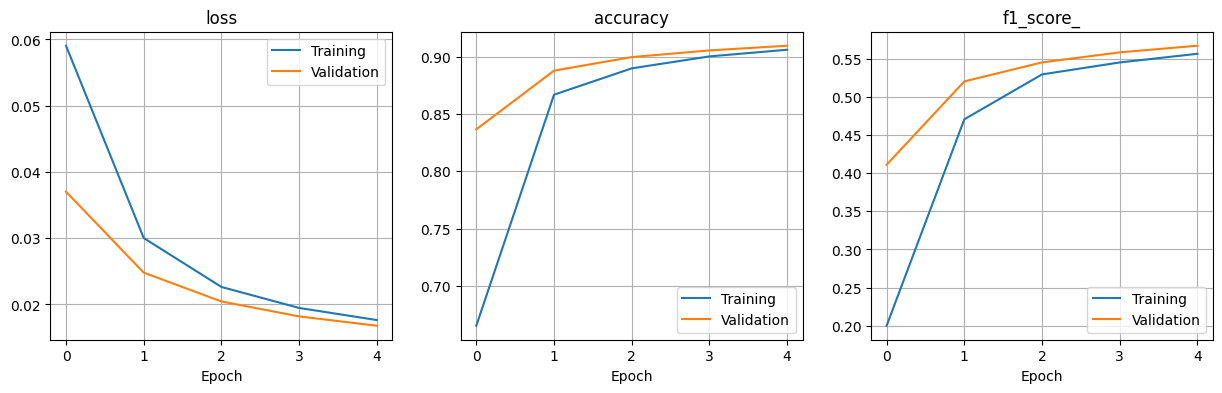

In [9]:
plot_training_history(train_va)

## Task 2.4: Compare the results from the TensorFlow implementation with the Numpy implementation
**Question 2.4.1**: How long did it take to train the TensorFlow implementation of the network on the *entire* dataset for five epochs compared to the time it took to train the Numpy implementation?

**Question 2.4.2**: What is the biggest (defining) difference in how the TensorFlow implementation **was trained** compared to the Numpy implementation?

**Question 2.4.3**: Were there any significant differences in the ease of implementation and the amount of code needed for the TensorFlow and Numpy implementations?

**Answer 2.4.1**:
The one impelemeted in numpy uses 4 minutes and 15 seconds to train the network where the keras implememtation uses 46 seconds.

**Answer 2.4.2**:The numpy implementation does not update the weights in batches but after all samples where the keras implemetation opreates with batches.

**Answer 2.4.3**: The code for the numpy version requires many lines more than the code for the keras version of the  network. The keras implementation also seems much cleaner compared to the numpy version.

# Task 3: Design your own ANN architecture
As you probably noticed in the last task, the performance of the simple network with a single hidden layer and 30 hidden units does not perform particularily well. In this task you are free to design the network architecture for the MNIST handwritten digit recognition challenge with a couple of stipulations:
* use **only Dense or fully connected layers**,
* use both **accuracy and the F1-score** as performance metrics.

Otherwise, you are free to use whatever loss-function, optimizer and activation functions you want and train it for as many epochs you want.

## Task 3.1: Implement your own network architecture
Design your network below:

(Feel free to add as many code and markdown cells as you want)

In [10]:
model_cu = ks.models.Sequential(
    [
        ks.layers.Input((28,28)), # input layer
        ks.layers.Flatten(),
        ks.layers.Dense(200, activation='relu'),   # hidden layer
        ks.layers.Dense(50, activation='relu'),   # hidden layer
        ks.layers.Dense(20, activation='relu'),   # hidden layer
        ks.layers.Dense(10, activation='softmax') # output layer
        ])

model_cu.summary()

model_cu.compile(loss='MSE',
              optimizer=ks.optimizers.SGD(learning_rate=0.10),
              metrics=['accuracy', f1_score_])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 200)               157000    
                                                                 
 dense_3 (Dense)             (None, 50)                10050     
                                                                 
 dense_4 (Dense)             (None, 20)                1020      
                                                                 
 dense_5 (Dense)             (None, 10)                210       
                                                                 
Total params: 168280 (657.34 KB)
Trainable params: 168280 (657.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Task 3.2: Train your network and visualize the training history
Train the model and plot the training history in the code cell(s) below. Use the same method for plotting the training process as in the voluntary assignment. Feel free to use the function `plot_training_history()` from `utilities.py`

In [11]:
time_cu_start = time.time()
train_k = model_cu.fit(X_train, y_train, epochs=15, batch_size=10, validation_split=(1/6))
time_cu = time.time() - time_cu_start

Epoch 1/15
5000/5000 [==============================] - 14s 3ms/step - loss: 0.0333 - accuracy: 0.7609 - f1_score_: 0.4167 - val_loss: 0.0144 - val_accuracy: 0.9073 - val_f1_score_: 0.5786
Epoch 2/15
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0123 - accuracy: 0.9212 - f1_score_: 0.5865 - val_loss: 0.0106 - val_accuracy: 0.9324 - val_f1_score_: 0.6017
Epoch 3/15
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0092 - accuracy: 0.9409 - f1_score_: 0.6040 - val_loss: 0.0090 - val_accuracy: 0.9417 - val_f1_score_: 0.6071
Epoch 4/15
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0074 - accuracy: 0.9526 - f1_score_: 0.6136 - val_loss: 0.0073 - val_accuracy: 0.9532 - val_f1_score_: 0.6179
Epoch 5/15
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0062 - accuracy: 0.9611 - f1_score_: 0.6198 - val_loss: 0.0071 - val_accuracy: 0.9532 - val_f1_score_: 0.6184
Epoch 6/15
5000/5000 [==============================] -

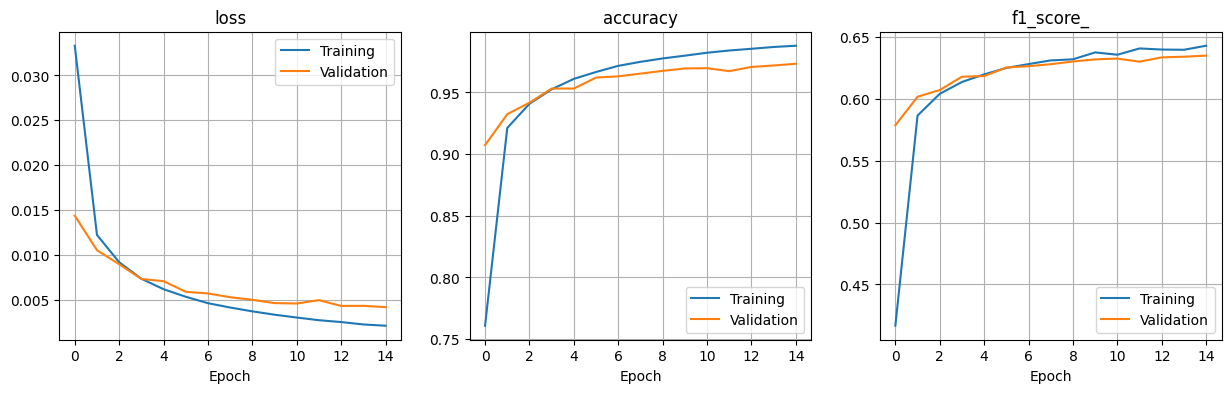

In [12]:
plot_training_history(train_k)

## Task 3.3: Discuss the results
**Question 3.3.1**: Compare the performance of your new model with the model from Task 2. Did the new model achieve higher accuracy and F1-score? What could be the reasons for that?

**Question 3.3.2**: Did overfitting occur? If so, after how many epochs? Does overfitting typically increase or decrease with the increasing model complexity?

**Question 3.3.3**: How do accuracy and F1-Score values compare (are they similar or very different from each other)? What does it tell you about the MNIST dataset and which one of these metrics is more reliable in this case?

**Question 3.3.4**: Explain **very briefly** how each of the following model hyperparameters can impact the model's performance:
- Number of layers
- Number of neurons in a layer
- Activation functions
- Learning rate.
- Regularization techniques (such as L2 regularization).

**Answer 3.3.1**: The custom model is sligtly better than the first model. THis might be because it is a bit more complex and therefore fits the dataset better.

**Answer 3.3.2**: It looks like there is some overfitting after the third epoch. This might occur because the model is to complex and fits the training dataset too tightly.

**Answer 3.3.3**: The accuracy and f1 scores look very similar. This tells us that the dataset is balanced and the class distrubutions are good. This means that boot metrics can be good for this dataset. I would use accuracy since f1 score is better when there is a class inmbalance.

**Answer 3.3.4**:
- Number of layers:
 In a neural network the nmber of layers detetmines the networks depth, more layers mean that the model can capture more complex relationships and patterns in the data. This might lead to overfitting since the model can become quite complex.

- Number of neurons in a layer:
 The number of neurons in a layer determines how much information that layer can learn, this also increases the models complexity and can lead to overfitting.

- Activation functions:
 The activation function determines the output of a neuron, different activation functions can lead to different outcomes and different preformances in runtime. Choosing the wrong activaiton function can lead to the vanishing gradient problem, that slows down the learning of the model.

- Learning rate:
 The learning rate determines how big of a step we take in the weight space towards the minima. A too large learning rate might overshoot and a too small one might take too long time.

- Regularizatrion:
 Regularization aims to punsish large weights to combat overfitting. This adds a penalty term to the loss function based on the size of the weights, l2 regularization gives smaller weight wher l1 regularization makes some weights zero.
  



# Task 4: Design and train a _classical_ machine learning classifier
Pick your **favourite** machine learning classifer that you learned about in DAT200 and train it for the MNIST handwritten digits recognition problem. (Hint: use the scikit-learn library). Remember to use **accuracy and the F1-score** as performance metrics.

In [13]:
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=10, eval_metric='merror')

In [14]:
time_xgb_start = time.time()
xgb_model.fit(X_traing_xgb, y_train_xgb, verbose=True)
time_xgb = time.time() - time_xgb_start

# Task 5: Compare and discuss
Evaluate the four models you have implemented in task 2, 3 and 4 on the test dataset and compare them based on
* Accuracies and F1-scores they attain
* Time it takes to train them

Did you experience any trouble when training models in tasks 2-4?

In [15]:
y_pred_va = model_va.predict(X_test)
y_pred_cu = model_cu.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test_xgb.reshape(X_test_xgb.shape[0], -1))

y_pred_va_labels = np.argmax(y_pred_va, axis=1)
y_pred_cu_labels = np.argmax(y_pred_cu, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy_va = accuracy_score(y_test_labels, y_pred_va_labels)
f1_va = f1_score(y_test_labels, y_pred_va_labels, average='weighted')
accuracy_cu = accuracy_score(y_test_labels, y_pred_cu_labels)
f1_cu = f1_score(y_test_labels, y_pred_cu_labels, average='weighted')
accuracy_xgb = accuracy_score(y_test_xgb, y_pred_xgb)
f1_xgb = f1_score(y_test_xgb, y_pred_xgb, average='weighted')

print(f'For the validation model:')
print(f'Accuracy: {accuracy_va}')
print(f'F1-score: {f1_va}')
print(f'Time: {time_va} \n')
print(f'For the custom model:')
print(f'Accuracy: {accuracy_cu}')
print(f'F1-score: {f1_cu} \n')
print(f'Time: {time_cu}')
print(f'For the xgboost model:')
print(f'Accuracy: {accuracy_xgb}')
print(f'F1-score: {f1_xgb}')
print(f'Time: {time_xgb}')

313/313 [==============================] - 1s 2ms/step
For the validation model:
Accuracy: 0.9136
F1-score: 0.9130638984247882
Time: 46.190579652786255 

For the custom model:
Accuracy: 0.973
F1-score: 0.9730009851676695 

Time: 191.51566767692566
For the xgboost model:
Accuracy: 0.9795
F1-score: 0.9795008778306383
Time: 103.10663104057312


**Task 5 discussion Here:**


It seems like the XGBoost performs better than the neural networks, but the custom networks works a bit better than the network from the va. However the xgboost is much slower than the nn to train.